In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM
# from keras_tqdm import TQDMNotebookCallback
from ipywidgets import interact

# from bokeh.io import push_notebook, show, output_notebook
# from bokeh.plotting import figure
# output_notebook()
# import mpld3
# mpld3.enable_notebook()

% matplotlib inline

print("All dependencies imported!! TF: {} ; Keras :{}".format(tf.__version__,keras.__version__))

!(date +%d\ %B\ %G)

All dependencies imported!! TF: 1.0.0 ; Keras :2.0.6
22 August 2017


# Load Helper Functions

In [5]:
def load_encoders():
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()
    
    src_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    dst_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    type_encoder.classes_ = np.load('encoders/type.npy')
    activity_encoder.classes_ = np.load('encoders/activity.npy')
    protocol_encoder.classes_ = np.load('encoders/protocol.npy')
    t_endpoint_encoder.classes_ = np.load('encoders/endpoint.npy')
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def train_encoders(rucio_data, use_cache=True):
    
    if use_cache:
        if os.path.isfile('encoders/ddm_rse_endpoints.npy') and os.path.isfile('encoders/activity.npy'):
            print('using cached LabelEncoders for encoding data.....')
            src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder=load_encoders()
        else:
            print('NO cache found')
    else:
        print('No cached encoders found ! Training Some New Ones using input data!')
        src_encoder = LabelEncoder()
        dst_encoder = LabelEncoder()
        type_encoder = LabelEncoder()
        activity_encoder = LabelEncoder()
        protocol_encoder = LabelEncoder()
        t_endpoint_encoder = LabelEncoder()

        src_encoder.fit(rucio_data['src-rse'].unique())
        dst_encoder.fit(rucio_data['dst-rse'].unique())
        type_encoder.fit(rucio_data['src-type'].unique())
        activity_encoder.fit(rucio_data['activity'].unique())
        protocol_encoder.fit(rucio_data['protocol'].unique())
        t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

        np.save('encoders/src.npy', src_encoder.classes_)
        np.save('encoders/dst.npy', dst_encoder.classes_)
        np.save('encoders/type.npy', type_encoder.classes_)
        np.save('encoders/activity.npy', activity_encoder.classes_)
        np.save('encoders/protocol.npy', protocol_encoder.classes_)
        np.save('encoders/endpoint.npy', t_endpoint_encoder.classes_)
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def preprocess_data(rucio_data, use_cache=True):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','previous-request-id','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT, add dataetime index
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')
    
    # Reindex data with 'submitted_at timestamp'
    rucio_data.index = pd.DatetimeIndex(rucio_data['submitted_at'])
    
    #remove all timestamp columns
    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    # encode categorical data
 
    if use_cache==True:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=True)
    else:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=False)

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data


def rescale_data(rucio_data, durations):
    # Normalization
    # using custom scaling parameters (based on trends of the following variables)

#     durations = durations / 1e3
    rucio_data['bytes'] = rucio_data['bytes'] / 1e8
    rucio_data['delay'] = rucio_data['delay'] / 1e3
#     rucio_data['src-rse'] = rucio_data['src-rse'] / 1e2
#     rucio_data['dst-rse'] = rucio_data['dst-rse'] / 1e2
    
    return rucio_data, durations


# get data

In [6]:
rucio_data = pd.read_csv('../data/atlas_rucio-events-2017.08.06.csv')

In [12]:
rucio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
Unnamed: 0             20000 non-null int64
account                0 non-null float64
activity               20000 non-null object
bytes                  20000 non-null int64
checksum-adler         20000 non-null object
checksum-md5           0 non-null float64
dst-rse                20000 non-null object
dst-type               20000 non-null object
dst-url                20000 non-null object
duration               20000 non-null int64
guid                   0 non-null float64
name                   20000 non-null object
previous-request-id    153 non-null object
protocol               20000 non-null object
reason                 0 non-null float64
request-id             20000 non-null object
scope                  20000 non-null object
src-rse                20000 non-null object
src-type               20000 non-null object
src-url                20000 non-null object
started_

In [18]:
rucio_data = preprocess_data(rucio_data)
rucio_data.head(10)

,activity,bytes,dst-rse,dst-type,duration,protocol,scope,src-rse,src-type,transfer-endpoint,delay
9167,1,4393179482,0,0,591,1,2,13,1,0,417144.0
12657,1,462100840,29,1,643,1,2,27,0,3,336128.0
7734,1,2591908099,74,0,1517,1,2,13,1,2,245386.0
7730,1,4446261985,74,0,2374,1,2,13,1,2,244495.0
3190,1,3730298265,74,0,1397,1,2,13,1,2,246493.0
3183,1,3504631407,74,0,1893,1,2,13,1,2,245870.0
3200,1,4138079256,74,0,2048,1,2,13,1,2,245398.0
3186,1,4548232186,74,0,2379,1,2,13,1,2,244808.0
3182,1,3498196209,74,0,1693,1,2,13,1,2,246035.0
16783,1,2225816,9,0,99,1,2,113,0,0,217497.0


In [20]:
durations = rucio_data['duration']
rucio_data = rucio_data.drop(['duration'], axis=1)

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 19:18:26.982655. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
durations.shape

(20000,)

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 19:22:59.052208. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
train_fraction = 0.8
data_size = rucio_data.shape[0]
split_index = int(train_fraction * data_size)
# print(split_index)
trainX,trainY,testX,testY=rucio_data[:split_index],durations[:split_index],rucio_data[split_index:],durations[split_index:]


/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 19:27:18.312467. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [46]:
print(trainX.shape,'\t', trainY.shape)

(16000, 10) 	 (16000,)


/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 19:35:38.789037. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [70]:
import keras.callbacks as cb

class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 19:58:09.678924. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
def init_model():
    start_time= time.time()
    print('Compiling model ...')
    
    model = Sequential()
    model.add(Dense(512, input_dim=10,init='normal', activation='tanh'))

    model.add(Dense(512,init='normal', activation='linear'))
    model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(512, init='normal', activation='tanh'))
    model.add(Dense(256, init='normal', activation='relu'))  # relu
    # model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(256, init='normal', activation='linear'))
    model.add(Dense(256, init='normal', activation = 'relu'))  # extra
    model.add(Dense(128, init='normal', activation='relu'))    # relu
    model.add(Dense(1))
    
    adam = Adam(lr=0.001, decay= 0.0002)
#     adam = Adam(lr=0.01, decay = 0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam, metric=['mean_squared_error'])
    print('Model compield in {0} seconds'.format(time.time() - start_time))
    return model

In [101]:
def run_network(model=None, epochs=20, batch=256):
    try:
        start_time = time.time()

        if model is None:
            model = init_model()

        history = LossHistory()

        print('Training model...')
        training = model.fit(trainX.as_matrix(), trainY.as_matrix(), epochs=epochs, batch_size=batch,
                             validation_split=0.1, callbacks=[history], verbose=1)

        print("Training duration : {0}".format(time.time() - start_time))
        score = model.evaluate(trainX.as_matrix(), trainY.as_matrix(), verbose=0)

        print("Network's training score [MSE]: {0}".format(score))
        print("Training finished !!!!!!")
        return training, model, history.losses
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        return model, history.losses

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:32:16.554009. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [102]:
def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()
    print(len(losses))

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:32:17.942217. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Compiling model ...


/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", input_dim=10, activation="tanh")`
  '` call to the Keras 2 API: ' + signature)
/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/keras/utils/generic_utils.py:135: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(cls.from_config)
/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/keras/utils/generic_utils.py:135: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(cls.from_config)
/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", activation="linear")`
  '` call to the Keras 2 API: ' + signature)
/home/vyom/anaco

Model compield in 11.800450563430786 seconds
Training model...


/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2096: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 14400 samples, validate on 1600 samples
Epoch 1/20
14400/14400 [==============================] - 20s - loss: 50304.3853 - val_loss: 15217.8975
Epoch 2/20
14400/14400 [==============================] - 16s - loss: 50065.9517 - val_loss: 14910.8252

/home/vyom/anaconda3/envs/CERN/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


160


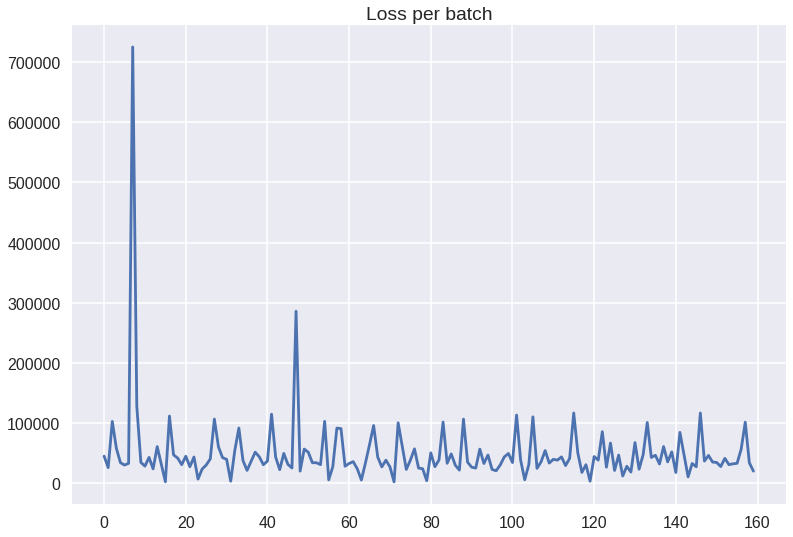

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:32:50.537477. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [104]:
training, model, losses = run_network(epochs= 20, batch=2048)
plot_losses(losses)

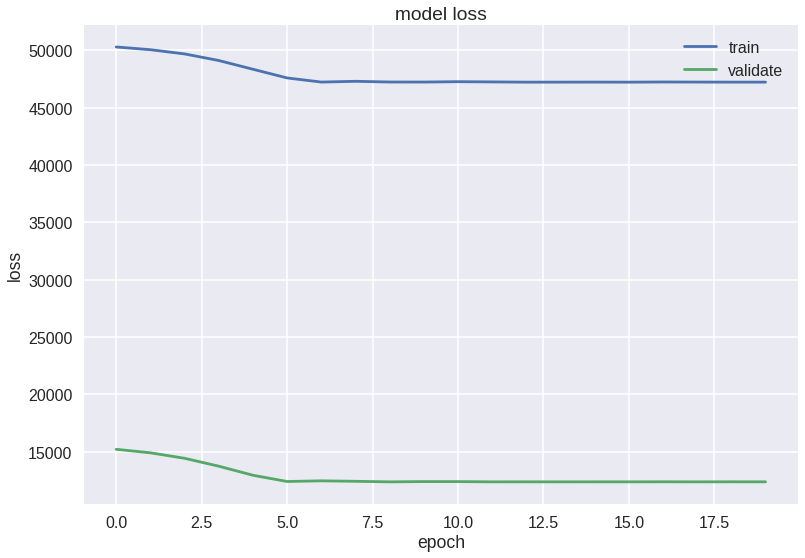

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:39:42.658751. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [105]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [106]:
score = model.evaluate(testX.as_matrix(), testY.as_matrix(), verbose=2)

print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

predictions=model.predict((testX[:1000]).as_matrix())

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:39:53.304251. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


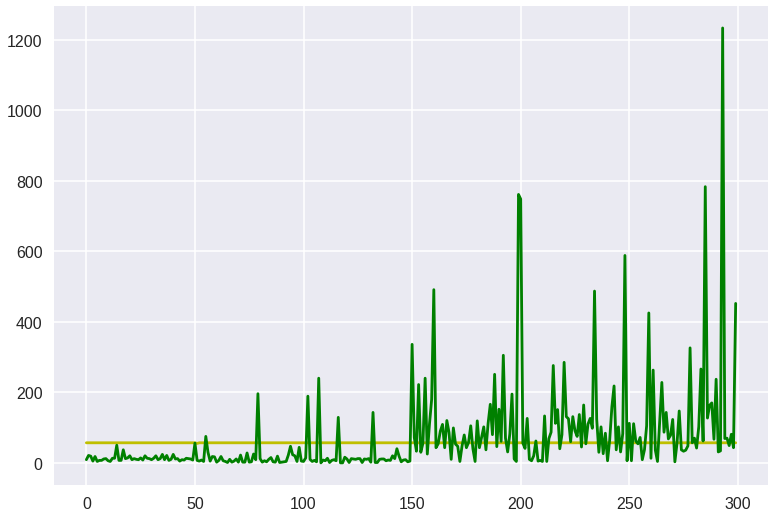

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:40:02.822616. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [109]:
sns.set_context('poster')

# plotting a portion of the test values against the predicted output

plt.plot(predictions[:300,0],'y' )
plt.plot(testY[:300].as_matrix(), 'g')

plt.show()

In [110]:


p = figure(plot_width=950, plot_height=500)
p.line(x=list(range(len(predictions[:200,0]))), y=predictions[:200,0], color='#008000')
p.line(x=list(range(len(predictions[:200,0]))), y=testY[:200])
show(p)

# q = figure(plot_width=950, plot_height=500)
# q.line(x=list(range(len(predictions[:200,0]))), y=testY[:200])
# show(q)

/home/vyom/anaconda3/envs/CERN/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-06-19 20:40:09.796775. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
